## Background

Transcription factors are proteins that bind DNA at promoters to drive gene expression. Most preferentially bind to specific sequences while ignoring others. Traditional methods to determine these sequences (called motifs) have assumed that binding sites in the genome are all independent. However, in some cases people have identified motifs where positional interdependencies exist.

We will implement a multi-layer fully connected neural network to predict whether a short DNA sequence is a binding site for the yeast transcription factor Rap1. The training data is incredibly imbalanced, with way fewer positive sequences than negative sequences, so we will implement a sampling scheme to ensure that class imbalance does not affect training.

### Read in the all the positive and negative Rap1 motif examples.

In [22]:
from neural import *
import matplotlib.pyplot as plt
from math import floor

positives = read_text_file('data/rap1-lieb-positives.txt')
negatives = read_fasta_file('data/yeast-upstream-1k-negative.fa')

# Remove duplicates
positives = list(set(positives))
negatives = list(set(negatives))


### Assign indices for training and test sets. 

It is crucial that we perform preprocessing steps on the training and test sets *separately*.

In [23]:
np.random.seed(462)
#------------------------------Training set----------------------------------#

# Positive class examples
pos_train_indices = np.random.choice(range(len(positives)), floor(len(positives) * 0.8),  replace=False)

X_train_pos = [positives[i] for i in pos_train_indices]

# Negative class examples
neg_train_indices = np.random.choice(range(len(negatives)), floor(len(negatives) * 0.8),  replace=False)

X_train_neg = [negatives[i] for i in neg_train_indices]
#---------------------------------------------------------------------------#


#---------------------------------Test set-----------------------------------#

X_test_pos = list(set(positives) - set(X_train_pos))
X_test_neg = list(set(negatives) - set(X_train_neg))

#---------------------------------------------------------------------------#

The negative sequences are much longer than the positive sequences, so we need to process them to the same length. 
We don't want to lose more information than necessary while trimming from 1000 bp to 17 bp, and we also don't know enough about the origin of the data to know whether regularly tiling the long sequences (e.g. 0:17, 17:34, 34:51, ...) would introduce bias. For example, a consequence of this tiling strategy would be that the 7 bp region from 14:21 would never appear in our dataset. 

In order to reduce the potential for bias and retain as much information from our sequences as possible without letting the dataset become too large or redundant, we will use the following strategy:

1. Choose a starting index __a__ between 0 and 16. 
2. For all integers __k__ between 0 and floor((1000-__a__)/17) - 1:
    - Add a subsequence __s__ = __S__[__i__ : __i__+17] to the dataset such that __i__ = 17*__k__ + __a__


In [24]:
#------------------------------Training set----------------------------------#

# Split long sequences
X_train_neg = get_subseqs(seq_arr=X_train_neg, new_length=17, seed=462)

# Assign labels
y_train_pos = [True for _ in X_train_pos]
y_train_neg = [False for _ in X_train_neg]

#---------------------------------------------------------------------------#


#-------------------------------Test set------------------------------------#

# Split long sequences
X_test_neg = get_subseqs(seq_arr=X_test_neg, new_length=17, seed=462)

# Assign labels
y_test_pos = [True for _ in X_test_pos]
y_test_neg = [False for _ in X_test_neg]

#---------------------------------------------------------------------------#


Now that we have processed all sequences to 17 bp, we can combine the negative and positive examples back together.

In [25]:
X_train = X_train_pos + X_train_neg
y_train = y_train_pos + y_train_neg

X_test = X_test_pos + X_test_neg
y_test = y_test_pos + y_test_neg


### Choose a model architecture and train.

I observed saw excellent classification performance with even a very simple, one-layer model with a sigmoid activation function. Increasing the number of layers yielded a very small increase in predictive performance. Because performance was so good, and the model converged so quickly, I kept the initial learning rate and batch size I tried (0.01 and 1024), and reduced the number of training epochs from 10 to 8 to speed up training.

Binary cross entropy loss is the standard loss function for binary classification tasks. Specifically, minimizing the binary cross-entropy loss minimizes the KL divergence between the empirical distribution of our labeled data and the distribution derived from our model predictions.

In [26]:
nn_arch = [
    {
        'input_dim': 68,
        'output_dim': 16, 
        'activation': 'relu'
    },
    {
        'input_dim': 16, 
        'output_dim': 68, 
        'activation': 'relu'
    },
    {
        'input_dim': 68,
        'output_dim': 1, 
        'activation': 'sigmoid'
    }
]

lr = 0.01
seed = 462
batch_size = 1024
epochs = 8
loss_function = 'binary_cross_entropy'


### Balancing classes using sample_seq.

Due to the small size of the minority class, downsampling the majority class to this size would result in too few training examples to effectively train a deep neural network. Instead, we will upsample the minority class to achieve class balance.

We should keep in mind that we are determining the class ratios *before* splitting into train/test sets. So we should be cautious about our model's ability to generalize to new datasets with a different distribution of positive/negative labels than the 50/50 ratio we are enforcing here. Also, we should remember that a model will be correct 50% of the time by following any of these strategies:
    
1. Always predict 1
2. Always predict 2
3. Randomly predict 0 or 1, each with probability 0.5.

We will perform this upsampling on each fold separately during cross-validation in order to prevent data leakage. 

In [27]:
from sklearn.model_selection import KFold
from sklearn import metrics

# 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=462)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Keep track of training and validation loss for each CV fold
train_loss_list = []
val_loss_list = []


for i, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
    
    print(f'Fold {i + 1}:')

    # Initialize model
    net = NeuralNetwork(nn_arch,
                    lr,
                    seed,
                    batch_size,
                    epochs,
                    loss_function)
    
    # Get train, val splits
    X_train_fold = X_train[train_idx]
    y_train_fold = y_train[train_idx]
    X_val_fold = X_train[val_idx]
    y_val_fold = y_train[val_idx]

    # Upsample the train and val folds separately so that sequences aren't shared between them
    X_train_fold, y_train_fold = sample_seqs(seqs=list(X_train_fold), labels=list(y_train_fold), seed=462)
    X_val_fold, y_val_fold = sample_seqs(seqs=list(X_val_fold), labels=list(y_val_fold), seed=462)

    # One-hot encode sequences
    X_train_fold = one_hot_encode_seqs(X_train_fold).reshape((len(y_train_fold), -1))
    X_val_fold = one_hot_encode_seqs(X_val_fold).reshape((len(y_val_fold), -1))

    # Convert booleans to float32
    y_train_fold = np.array(y_train_fold, dtype=np.float32)
    y_val_fold = np.array(y_val_fold, dtype=np.float32)
    
    # Train and validate
    per_epoch_loss_train, per_epoch_loss_val = net.fit(
        X_train_fold, 
        y_train_fold, 
        X_val_fold, 
        y_val_fold
        )
    
    # Compute validation accuracy
    preds = np.round(np.squeeze(net.predict(X_val_fold)))
    print("Validation set accuracy:", metrics.accuracy_score(y_val_fold, preds))
    
    # Append loss record to list
    train_loss_list.append(per_epoch_loss_train)
    val_loss_list.append(per_epoch_loss_val)

Fold 1:
Validation set accuracy: 0.9976631499364239
Fold 2:
Validation set accuracy: 0.9978175694253506
Fold 3:
Validation set accuracy: 0.9977139910622207
Fold 4:
Validation set accuracy: 0.9977660927243358
Fold 5:
Validation set accuracy: 0.9976122582196723


### Visualize training and validation loss for each CV fold

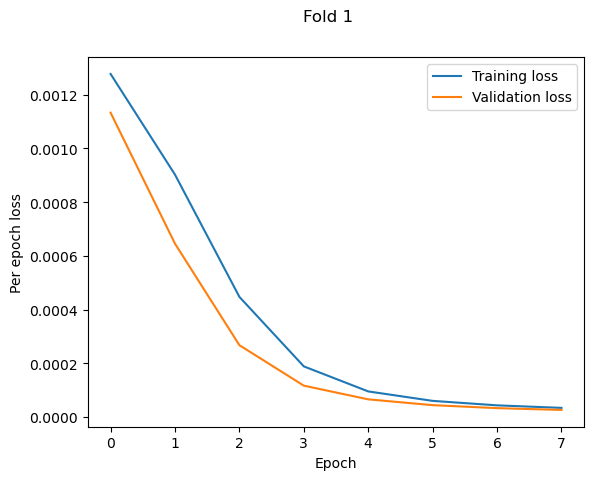

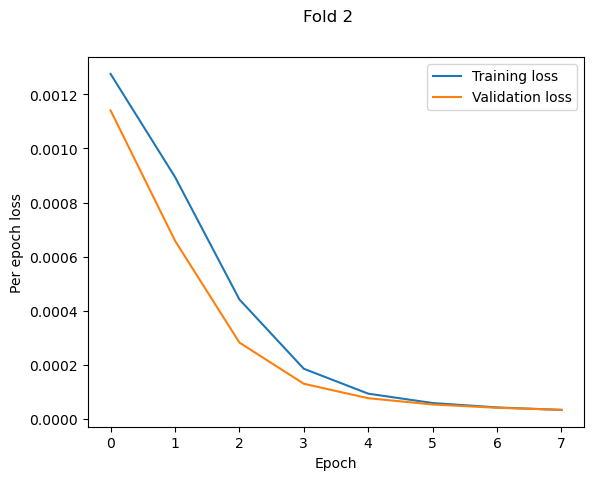

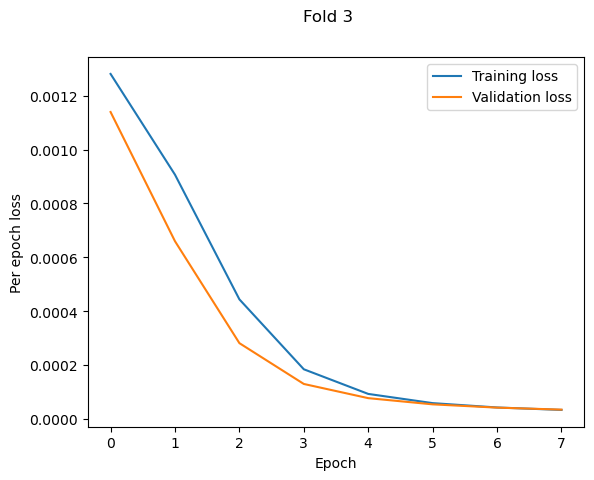

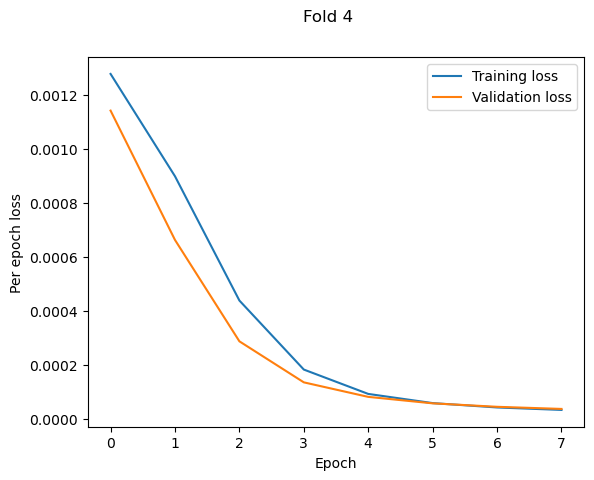

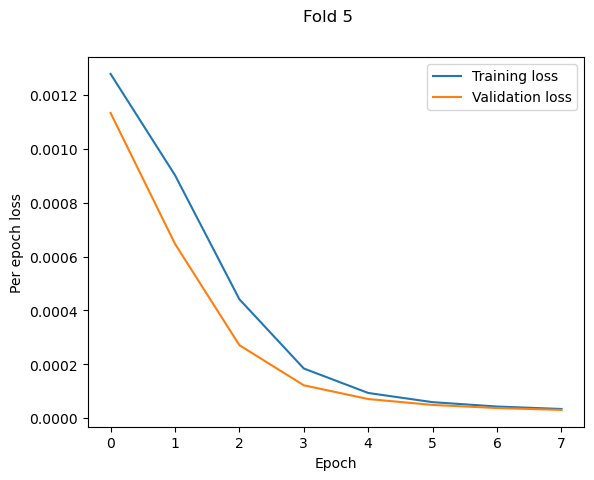

In [28]:
for i in range(5):
    plt.suptitle(f'Fold {i+1}')
    plt.plot(np.array(train_loss_list[i]) / (len(X_train)*.8))
    plt.plot(np.array(val_loss_list[i]) / (len(X_train)*.2))
    plt.legend(labels = ['Training loss', 'Validation loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Per epoch loss')
    plt.show()

### Evaluate predictive performance on the held-out test set.

Performance was much better than I expected.  To confirm that there was no data leakage, I checked the intersection between the test and training sets. The number of sequences in the intersection was small (370) and was mostly due to sequences that were produced independently during processing the negative sequences down to 17 bp, and accounted for less than 0.2% of the training set.

In [29]:
print(len(set(X_train).intersection(set(X_test))) / len(X_train))
print(set(X_train).intersection(set(X_test)))


0.0017101883267627302
{'AAGTTAGAGGAAGCTGA', 'TTCGAAAATAAGGATAT', 'TGTGATTTAAACATATG', 'CGTAAATACTAGTTAGT', 'TGTTCTCCTTCTCATCG', 'CCGTTTCCCTGCGAGCC', 'AAGGATTGATAATGTAA', 'CCGCGTCAGCGGCGTTG', 'ACATACTATTGTTAATT', 'ATTAACTGAATTTTCTT', 'TGTTAAATTTTGTCTCT', 'TCTTCCTCTGCTAGACG', 'TAATATAAACAGTCTTA', 'CATCATCTTGAAGTAAG', 'ATAATCGTAATATTAGT', 'CCCTTAGGGGTTTCCAC', 'TCATACTATTGTCATAG', 'GGGAAGTAACCAGTTGT', 'TTTGCCACTGTCGTCAT', 'ATCCAAACTCAACCGCT', 'GGAATAAAAATCAACTA', 'TAGAATTGTGTAGAATT', 'GTACTCCCAATAGAGAC', 'AAATGACATGTTTGCCA', 'GGAATCCATAAAAGGGA', 'TTTCGAACAAAGGCGAA', 'GAGGAGTTAAAACTGAC', 'AAAAAAAAAAAAAAAAG', 'CATTTGTTCCTCCTTTT', 'CCGCCGGAAACAAGGTC', 'TCGAAACTTACAAAAAT', 'CCTCATGCAAGCAGTAC', 'TTTTTTTTTTTTTTTTT', 'GCCCAGCCCGCCACGTC', 'TAATTTAGATGACTATT', 'GAGGATTCCTATATCCT', 'TCTTAGTGAGATTTCTT', 'TCATTTTTTTTTTTTTT', 'AAAAATCCACTATCGTC', 'CTTGAGCCTTCTATCCT', 'TTGAAGAACCTCGTCAG', 'CCGATTATAAAACTGGG', 'ATCAACTAATAGTTATA', 'CGAGGAGAACTTCTAGT', 'TGCGTTTCAGCTTCCAC', 'TTCTCCTCGAGGATTTA', 'ACATTAACCA

The classifier was over 99.5% accurate on the held-out test set.

In [30]:
X_test_one_hot = one_hot_encode_seqs(X_test).reshape((len(y_test), -1))
preds = np.squeeze(net.predict(X_test_one_hot))
print(metrics.accuracy_score(y_test, np.round(preds)))

0.9952048225784355
